Spike-timing dependent plasticity

Adapted from Song, Miller and Abbott (2000) and Song and Abbott (2001)


In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
N = 1000         # number of exc. synapses
taum = 20*ms     # membrane time constant
taupre = 20*ms   # pre - post interval to strengthen ... pre first
taupost = taupre # pre - post interval to weaken ... post first
Ee = 0*mV        # E_rev for exc. 
vt = -54*mV      # AP threshold
vr = -60*mV      # V_rest
El = -74*mV      # E_rev for inh. 
taue = 5*ms      # time constant for exc. 
F = 10*Hz        # firing rate of Poisson spike train input
gmax = .015       # max peak conductance from 1 AP at exc. synapse. Dimensionless: unit of leakage g.
dApre = .005      # max strengthening
dApost = -dApre * taupre / taupost * 1.05   # max weakening (overall effect: weakening)


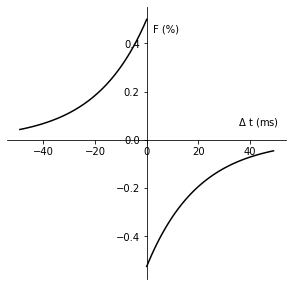

In [3]:
# visualize STDP function to reproduce Fig. 1
fig,ax = plt.subplots(figsize=(5,5))

dtpre = linspace(-49,0)*ms
dtpost = linspace(0,49)*ms
ax.plot(dtpre/ms,dApre*100*np.exp(dtpre/taupre),'k');
ax.plot(dtpost/ms,dApost*100*np.exp(-dtpost/taupost),'k')

#spine placement data centered
xlabel('$\Delta$ t (ms)')
ylabel('F (%)',rotation = 0)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_label_coords(0.9, 0.6)
ax.yaxis.set_label_coords(0.57, 0.9)


show()

In [4]:
ax

In [5]:
dApost *= gmax   # multiply by gmax to get max increase of peak conductance (gmax: postsyn vs. A: presyn?)
dApre *= gmax    # multiply by gmax to get max decrease of peak conductance

In [6]:
# integrate-and-fire model neuron, where exc. conductances decay exponentially. 

eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

# synaptic input of Poisson spike trains

input = PoissonGroup(N, rates=F)

# build a neuron with the model = diff eq defined above, with numerical integration method = euler  

neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='euler')

In [7]:
# define spike-timing dependent plasticity 

# after 1 presyn. AP: exc. conductance increase by the weight w, synapse strengthens by dApre, and weight updates by Apost, and bounded.  
# after 1 postsyn. AP: exc. synapse weaken by dApost, and weight updates by Apre, and bounded.


S = Synapses(input, neurons,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )


In [8]:
# add the synapse

S.connect()

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Build Tools for Visual Studio": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


In [9]:
# randomize initial weights
# record w and input spikes

S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
s_mon = SpikeMonitor(input)

Starting simulation at t=0. s for a duration of 100. s
6.6471 s (6%) simulated in 10s, estimated 2m 20s remaining.
13.092 s (13%) simulated in 20s, estimated 2m 13s remaining.
19.5468 s (19%) simulated in 30s, estimated 2m 3s remaining.
26.0719 s (26%) simulated in 40s, estimated 1m 53s remaining.
32.4084 s (32%) simulated in 50s, estimated 1m 44s remaining.
38.9116 s (38%) simulated in 1m 0s, estimated 1m 34s remaining.
45.529 s (45%) simulated in 1m 10s, estimated 1m 24s remaining.
51.8808 s (51%) simulated in 1m 20s, estimated 1m 14s remaining.
58.4382 s (58%) simulated in 1m 30s, estimated 1m 4s remaining.
65.0959 s (65%) simulated in 1m 40s, estimated 54s remaining.
71.7078 s (71%) simulated in 1m 50s, estimated 43s remaining.
78.2915 s (78%) simulated in 2m 0s, estimated 33s remaining.
84.861 s (84%) simulated in 2m 10s, estimated 23s remaining.
91.39 s (91%) simulated in 2m 20s, estimated 13s remaining.
97.9699 s (97%) simulated in 2m 30s, estimated 3s remaining.
100. s (100%) s

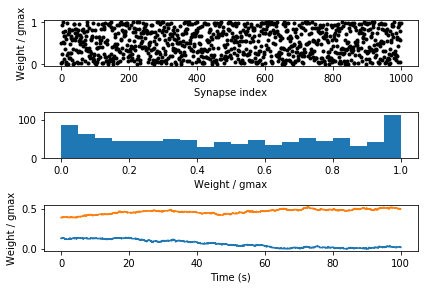

In [10]:
# run simulation and reproduce Fig. 2a of the paper: bimodel distribution of syn. conductances

run(100*second, report='text')

subplot(311)
plot(S.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(312)
hist(S.w / gmax, 20)
xlabel('Weight / gmax')
subplot(313)
plot(mon.t/second, mon.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
tight_layout()
show()

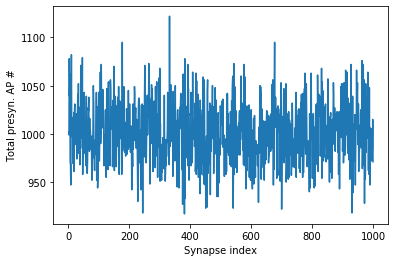

In [11]:
# plot presyn. spike counts

plot(linspace(1,1000,1000),s_mon.count)

xlabel('Synapse index')
ylabel('Total presyn. AP #')
show()